In [1]:
import os
import nibabel as nb
import nilearn
from nilearn import plotting
from nilearn import glm
import numpy as np
from nilearn import image
from atlasreader import create_output
from matplotlib import pyplot as plt
import string
plt.rcParams['figure.dpi'] = 300

subjlevel_folder = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/processed/z_maps/subject-level'
mask_template = '/scratch/hyruuk/neuromod/shinobi2023/cneuromod.processed/smriprep/{}/anat/{}_space-MNI152NLin2009cAsym_desc-brain_mask.png'
annotations=['HIT', 'JUMP', 'Kill', 'HealthLoss']

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [2]:
def load_data(subjlevel_folder, annotations=['HIT', 'JUMP', 'Kill', 'HealthLoss']):
    data_dict = {'fpath_list': [],
                 'subject_list': [],
                 'annot_list': [],
                 'binarized_list': []}
    for annot in annotations:
        annot_folder = os.path.join(subjlevel_folder, annot)
        for file in os.listdir(annot_folder):
            if '.nii.gz' in file:
                fpath = os.path.join(annot_folder, file)
                data_dict['fpath_list'].append(fpath)
                thresholded_map = glm.threshold_stats_img(fpath, threshold=3)[0].get_fdata()
                binarized_map = np.where(thresholded_map != 0, 1, thresholded_map)
                data_dict['binarized_list'].append(binarized_map)
                data_dict['subject_list'].append(file.split('_')[0])
                data_dict['annot_list'].append(annot)
    return data_dict

data_dict = load_data(subjlevel_folder)


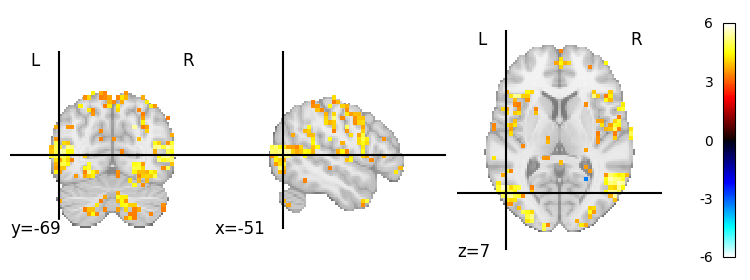

In [46]:
# Plot one beta map just to check
plotting.plot_stat_map(glm.threshold_stats_img(data_dict['fpath_list'][0], threshold=3)[0])

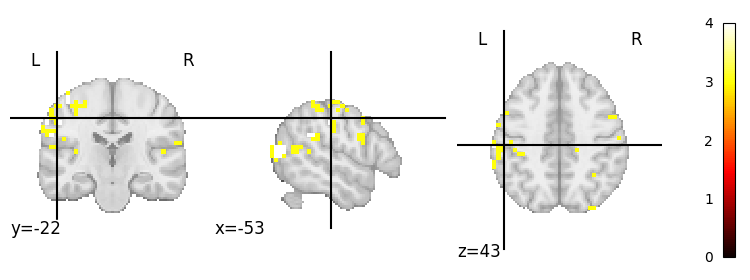

In [6]:
def get_top_voxels(data_dict, annot_to_plot):
#annot_to_plot = 'HIT'
    sublist = [data_dict['binarized_list'][idx] for idx, annot in enumerate(data_dict['annot_list']) if annot == annot_to_plot ]
    summed_image = image.new_img_like(nb.load(data_dict['fpath_list'][0]), 
                                      np.sum(np.stack(sublist), axis=0))
    top_voxels = image.threshold_img(summed_image, threshold=3)
    return top_voxels

top_voxels = get_top_voxels(data_dict, 'HIT')
plotting.plot_stat_map(top_voxels)

In [104]:
annot = 'JUMP'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=False,
    threshold=3,
    output_file=output_file,
    title=annot
)

In [118]:
annot = 'HIT'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=2,
    output_file=output_file,
    title=annot
)


In [119]:
annot = 'Kill'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=2,
    output_file=output_file,
    title=annot
)

In [107]:
annot = 'HealthLoss'
create_output(get_top_voxels(data_dict, annot), cluster_extent=20, voxel_thresh=3, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    get_top_voxels(data_dict, annot),
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    threshold=1,
    output_file=output_file,
    title=annot
)

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


In [108]:
# Prepare binarized maps for conjunction analysis
def binarize_map(annot_map):
    binarized_map = np.where(annot_map != 0, 1, annot_map)
    return binarized_map

HIT_map = binarize_map(get_top_voxels(data_dict, 'HIT').get_fdata())
Kill_map = binarize_map(get_top_voxels(data_dict, 'Kill').get_fdata())

In [109]:
# HIT - Kill
diff_voxels = HIT_map - Kill_map
diff_img = image.new_img_like(nb.load(data_dict['fpath_list'][0]), 
                                      diff_voxels)
annot = 'HIT-Kill'
create_output(diff_img, cluster_extent=20, voxel_thresh=1, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    diff_img,
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=0.5,
    output_file=output_file,
    title='HIT - Kill'
)


/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


In [111]:
diff_voxels = HIT_map*Kill_map
diff_img = image.new_img_like(nb.load(data_dict['fpath_list'][0]), 
                                      diff_voxels)

annot = 'HIT+Kill'
create_output(diff_img, cluster_extent=20, voxel_thresh=1, direction='both', outdir=f'../reports/atlasreader/{annot}')

output_file = f'../reports/atlasreader/{annot}/conjunction_{annot}.png'
plotting.plot_img_on_surf(
    diff_img,
    views=["lateral", "medial"],
    hemispheres=["left", "right"],
    inflate=True,
    symmetric_cbar=False,
    colorbar=True,
    threshold=0.5,
    output_file=output_file,
    title='HIT + Kill'
)

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


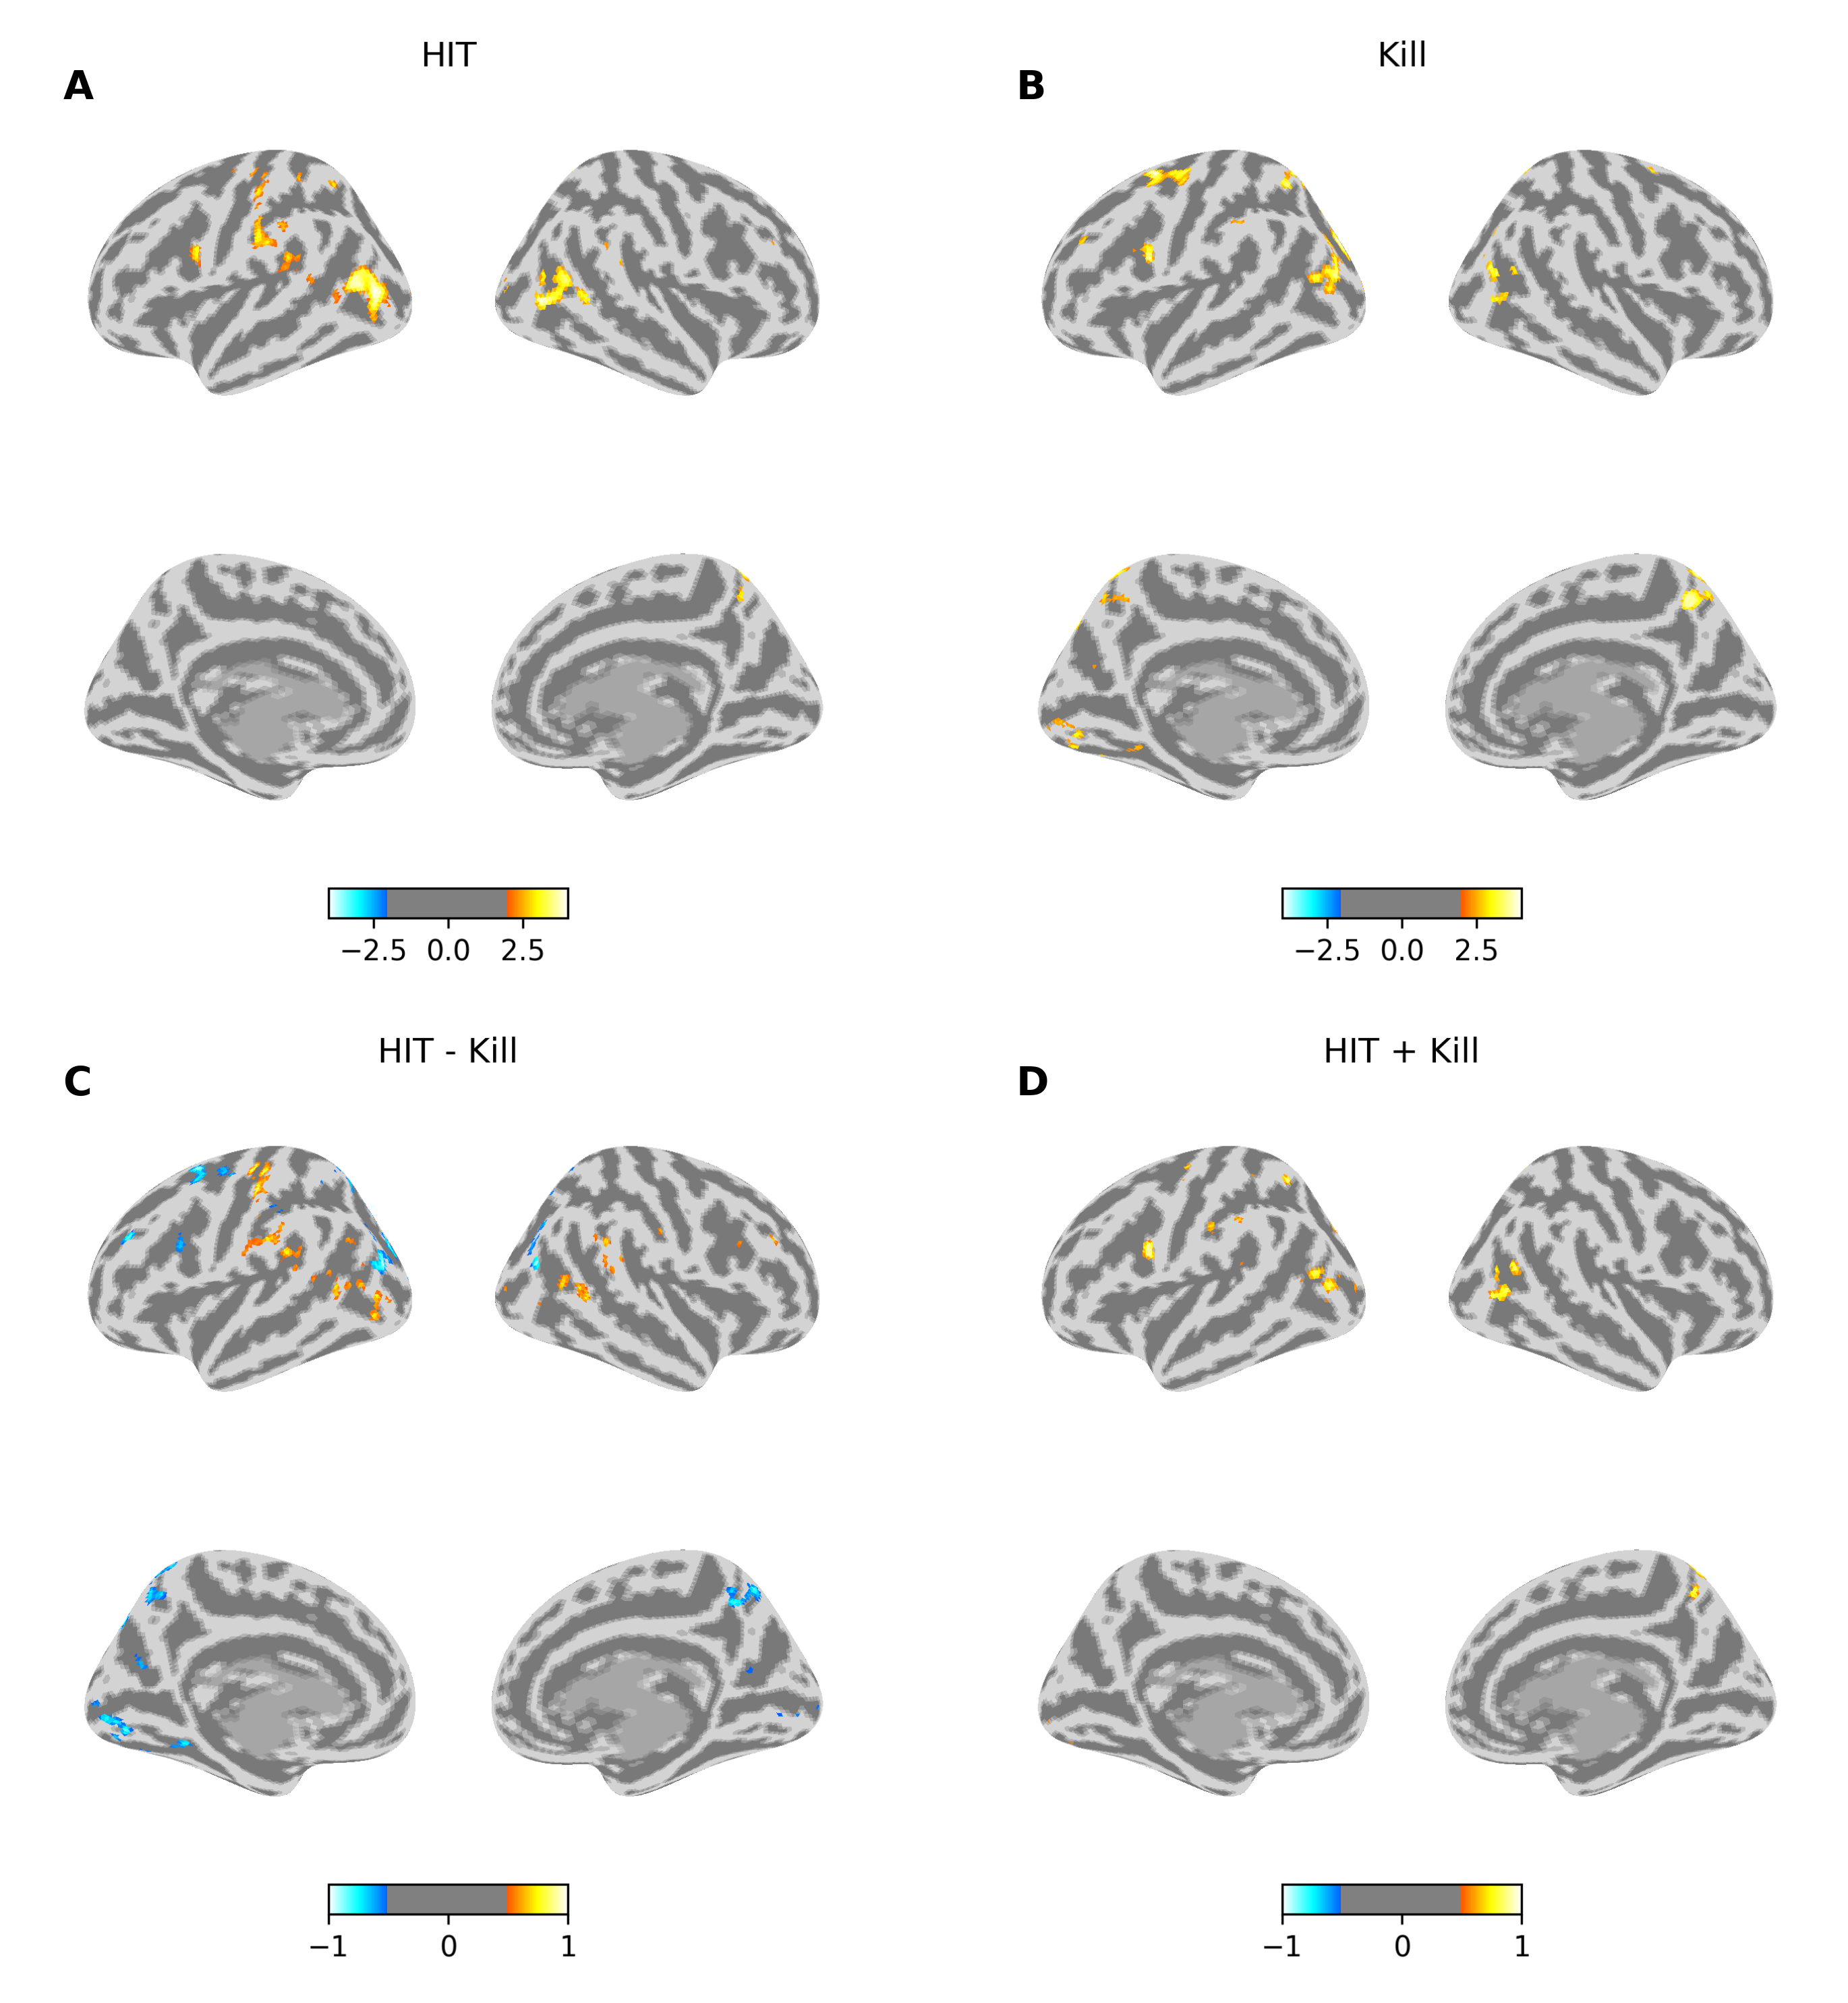

In [124]:
from PIL import Image

annotations = ['HIT', 'Kill', 'HIT-Kill', 'HIT+Kill']

# Make a nice 2 by 2 plot for the conjunction analysis
fig = plt.figure(figsize=(10, 10), dpi=300)
gs = fig.add_gridspec(2, 2)

ax_hit = fig.add_subplot(gs[0, 0])
ax_hit.imshow(Image.open(f'../reports/atlasreader/HIT/conjunction_HIT.png'))
ax_hit.axis('off')

ax_kill = fig.add_subplot(gs[0, 1])
ax_kill.imshow(Image.open(f'../reports/atlasreader/Kill/conjunction_Kill.png'))
ax_kill.axis('off')

ax_hit_min_kill = fig.add_subplot(gs[1, 0])
ax_hit_min_kill.imshow(Image.open(f'../reports/atlasreader/HIT-Kill/conjunction_HIT-Kill.png'))
ax_hit_min_kill.axis('off')

ax_hit_plus_kill = fig.add_subplot(gs[1, 1])
ax_hit_plus_kill.imshow(Image.open(f'../reports/atlasreader/HIT+Kill/conjunction_HIT+Kill.png'))
ax_hit_plus_kill.axis('off')


plt.tight_layout()

#for annot in annotations:
spot_names = string.ascii_uppercase[:4]
for idx, ax in enumerate([ax_hit, ax_kill, ax_hit_min_kill, ax_hit_plus_kill]):
    ax.text(0.05, 0.95, spot_names[idx], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', color='black')

/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  app.launch_new_instance()
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/_utils/niimg_conversions.py:326: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data, niimg.affine)
/home/hyruuk/mambaforge/envs/shinobi/lib/python3.7/site-packages/nilearn/_utils/niimg_conversions.py:326: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy an

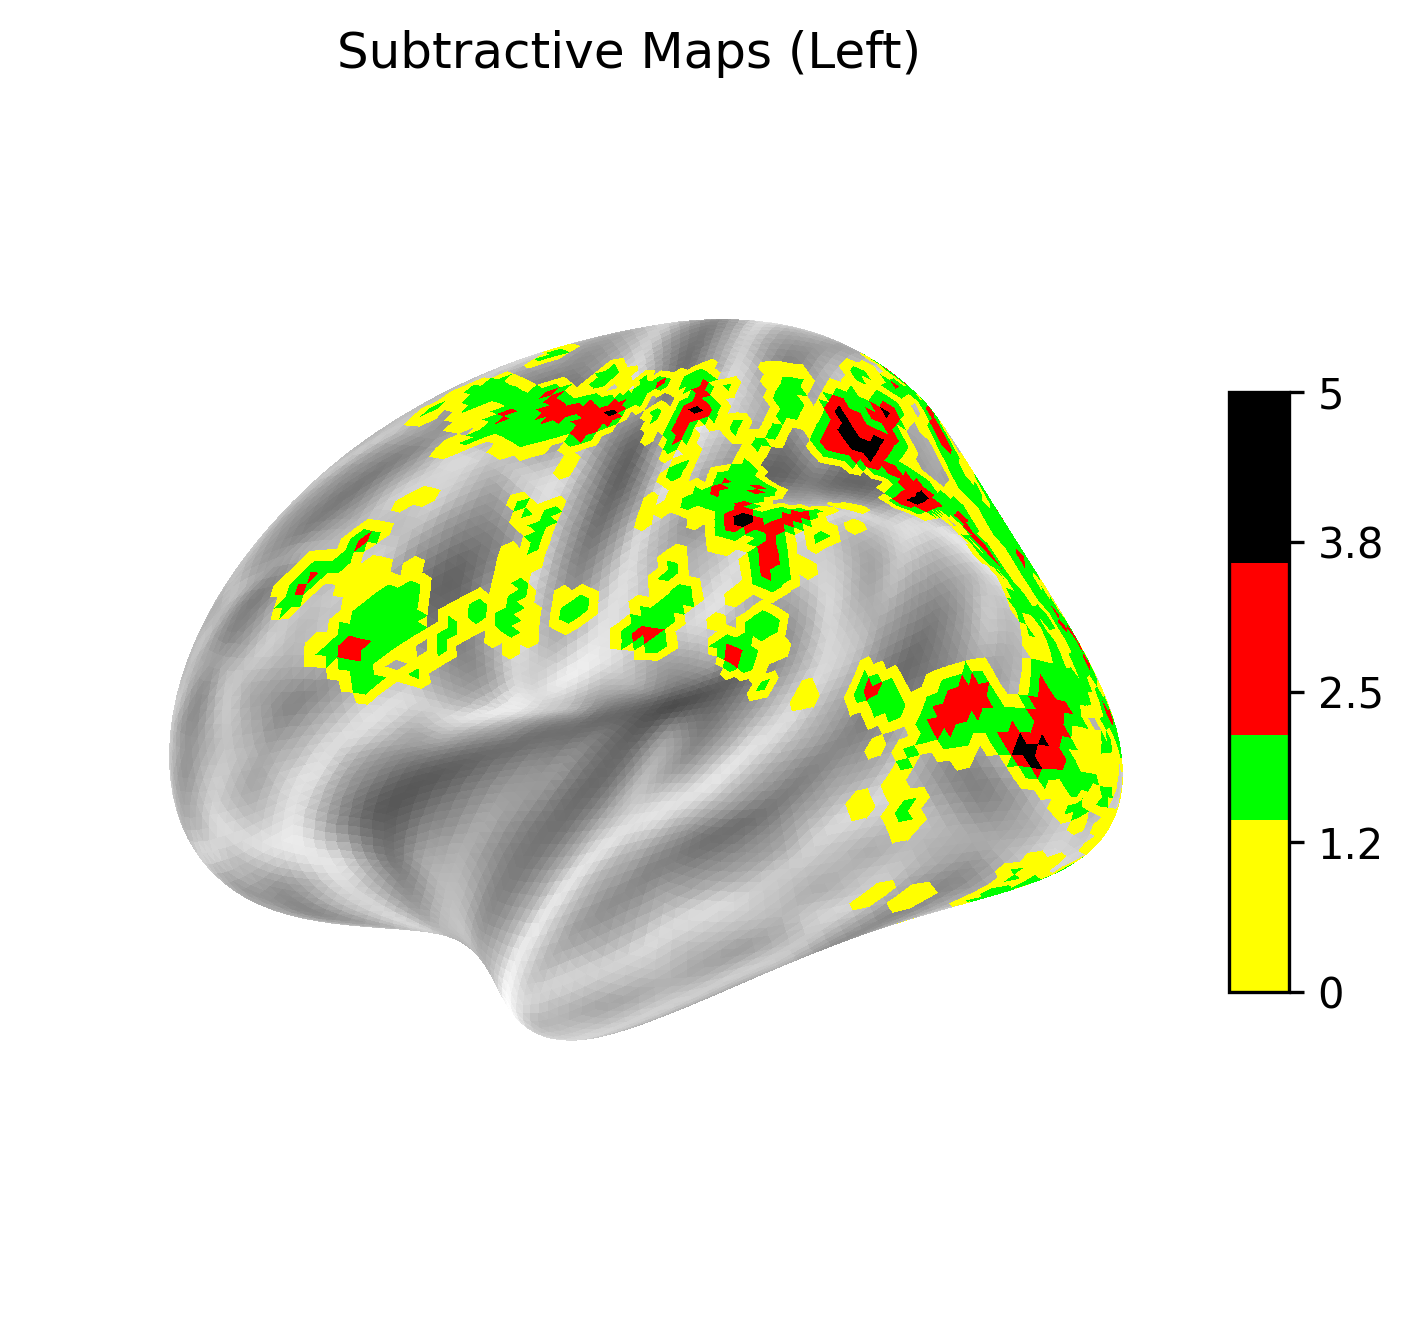

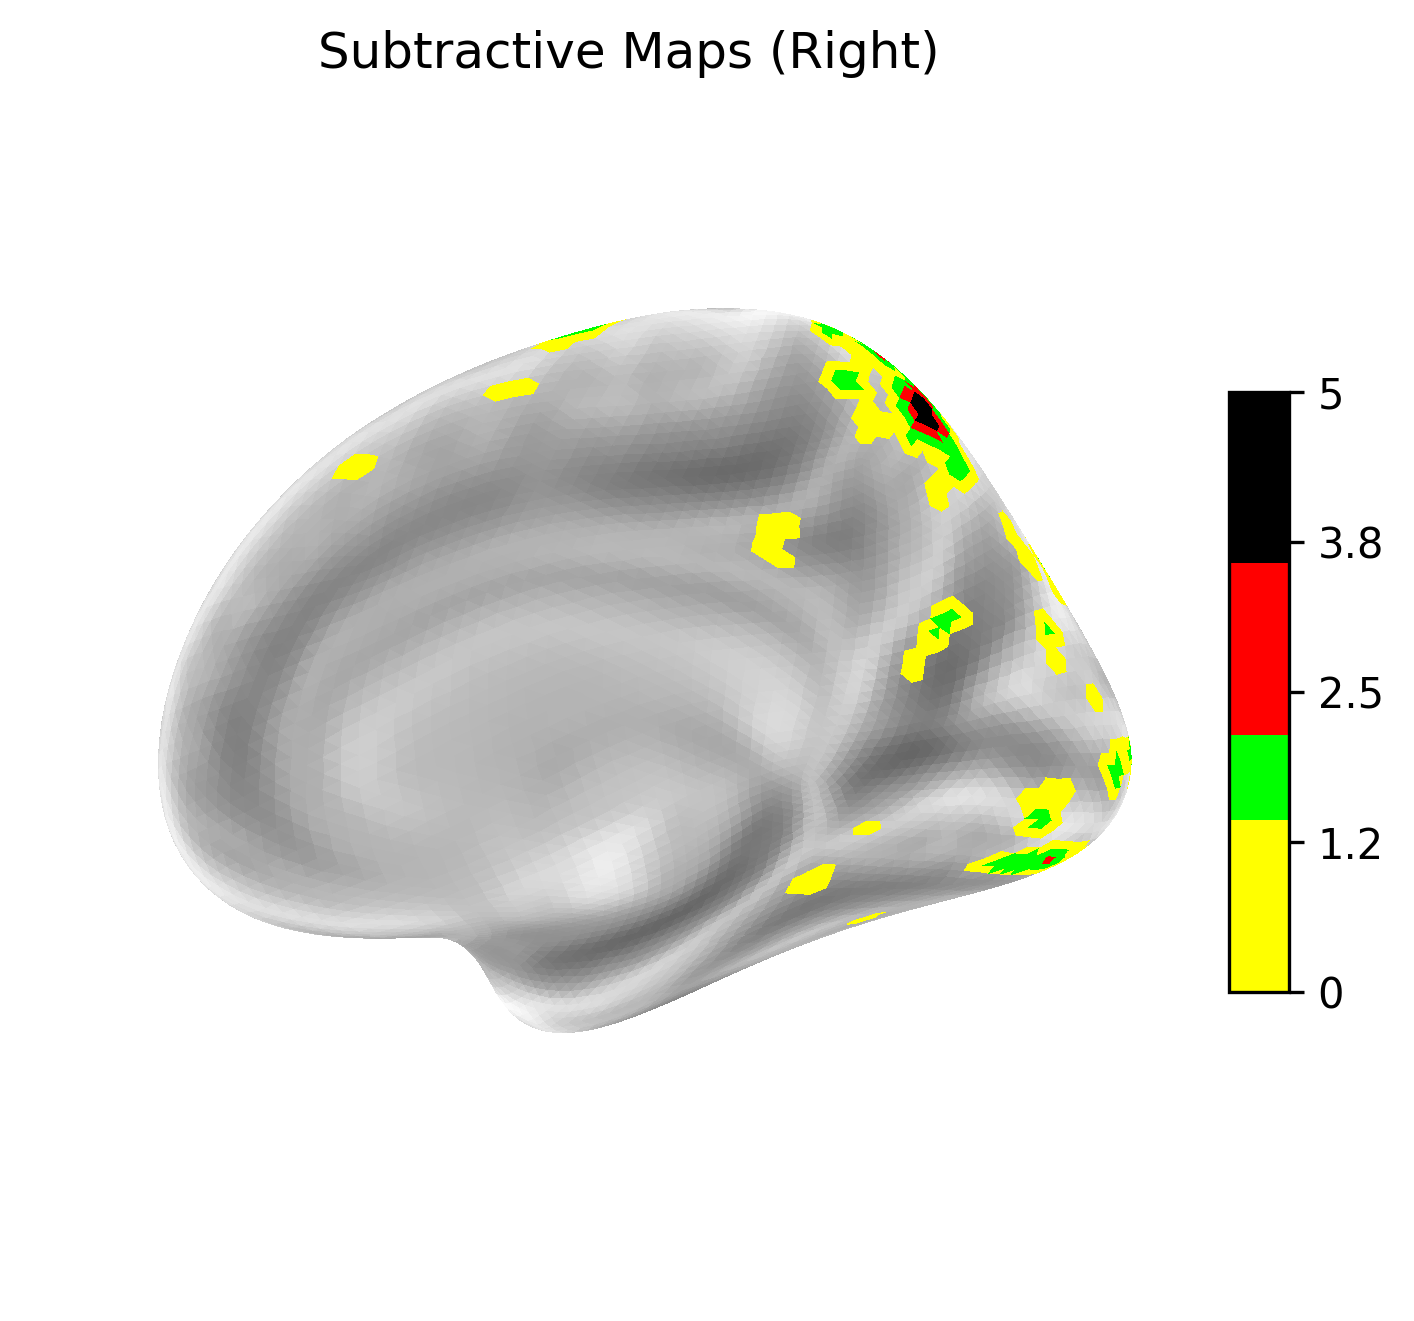

In [44]:
import nibabel as nib, numpy as np
from nilearn import datasets, surface, plotting
from matplotlib.colors import ListedColormap

def plot_subtractive_maps(flist, threshold=3.0):
    """Plot 1, 2 or 3 maps using subtractive (CMY) mixing."""
    if not 1 <= len(flist) <= 3: raise ValueError("Provide 1 to 3 NIfTI paths.")
    bin_maps = [(nib.load(f).get_fdata()>threshold).astype(int) for f in flist]
    combined = sum(bin_maps[i]*(2**i) for i in range(len(bin_maps)))
    cmaps = [
        ListedColormap([(0,0,0,0),(0,1,1,1)]),
        ListedColormap([(0,0,0,0),(0,1,1,1),(1,0,1,1),(0,0,1,1)]),
        ListedColormap([(0,0,0,0),(0,1,1,1),(1,0,1,1),(0,0,1,1),
                        (1,1,0,1),(0,1,0,1),(1,0,0,1),(0,0,0,1)])
    ]
    cmap = cmaps[len(bin_maps)-1]
    img = nib.Nifti1Image(combined, nib.load(flist[0]).affine)
    fsavg = datasets.fetch_surf_fsaverage()
    texl = np.round(surface.vol_to_surf(img, fsavg.pial_left)).astype(int)
    texr = np.round(surface.vol_to_surf(img, fsavg.pial_right)).astype(int)
    for hemi, tex, bg in [('left', texl, fsavg.sulc_left), ('right', texr, fsavg.sulc_right)]:
        plotting.plot_surf_stat_map(fsavg['infl_'+hemi], stat_map=tex, bg_map=bg,
                                    cmap=cmap, threshold=0.1, colorbar=True,
                                    title=f"Subtractive Maps ({hemi.capitalize()})")
    plotting.show()
    return img

# Example usage
map1_file = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/processed/z_maps/subject-level/HIT/sub-04_simplemodel_HIT.nii.gz'

# Or for two or three maps:
map2_file = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/processed/z_maps/subject-level/HealthLoss/sub-04_simplemodel_HealthLoss.nii.gz'
map3_file = '/home/hyruuk/GitHub/neuromod/shinobi_fmri/data/processed/z_maps/subject-level/Kill/sub-04_simplemodel_Kill.nii.gz'

#plot_subtractive_maps([map1_file], 3.0)  # Single map example
#plot_subtractive_maps([map2_file], 3.0)
#plot_subtractive_maps([map3_file], 3.0)

#plot_subtractive_maps([map1_file, map2_file], 3.0)          # Two-map example

img = plot_subtractive_maps([map1_file, map2_file, map3_file], 5.0)  # Three-map example
